In [1]:
import os
import sys

# Obtenha o caminho para o diretório pai do pacote "src"
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adicione o diretório pai do pacote "src" ao sys.path
sys.path.append(project_dir)

from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from src.services.database import db_manager
from src.utils.logging_config import get_logger
from src.services.tables_manager import drop_tables, create_tables, insert_data, configure_indexes

logger = get_logger(__name__)

In [2]:
# Limpar a base de dados antes de iniciar
drop_tables()
create_tables()
insert_data()
configure_indexes()

In [3]:
def save_model_config(product_id, export_id, value_column, model, model_type, additional_info=None):
    """
    Salva a configuração do modelo no banco de dados.
    Args:
        product_id (int): ID do produto para o qual o modelo foi treinado.
        export_id (int): ID da exportação relacionada.
        value_column (str): Coluna para a qual o modelo foi aplicado.
        model (object): Modelo treinado.
        model_type (str): Tipo do modelo ('ARIMA', 'RNN', etc.).
        additional_info (dict): Informações adicionais como parâmetros do modelo.
    """
    insert_query = """
    INSERT INTO model_config (product_id, export_id, value_column, model_type, parameters, aic, bic, date_executed)
    VALUES (%s, %s, %s, %s, %s, %s, %s, NOW());
    """
    params = (product_id, export_id, value_column, model_type, str(additional_info), model.aic, model.bic)
    try:
        db_manager.execute_query(insert_query, params)
        logger.info(f"Configuração do modelo {model_type} salva com sucesso para o produto {product_id} na coluna {value_column}.")
    except Exception as e:
        logger.error(f"Erro ao salvar configuração do modelo: {e}")

In [4]:
def prepare_time_series_data(table, product_column, date_column, value_column, product_id):
    """
    Prepara dados para análise de séries temporais por produto, filtrando apenas registros com valores nulos na coluna especificada.
    Args:
        table (str): Nome da tabela de produtos exportados.
        product_column (str): Nome da coluna que identifica o produto.
        date_column (str): Nome da coluna que identifica a data.
        value_column (str): Nome da coluna cujos valores nulos serão analisados.
        product_id (int): ID do produto para o qual os dados serão preparados.
    Returns:
        DataFrame: Contendo dados de série temporal para análise.
    """
    query = f"""
    SELECT vendasprodutosexport.ExportID, {date_column}, {table}.{product_column}, {value_column}
    FROM {table}
    JOIN vendasexport ON {table}.CodigoVenda = vendasexport.Codigo
    WHERE {product_column} = %s AND {value_column} IS NULL
    ORDER BY {date_column};
    """
    try:
        result = db_manager.execute_query(query, [product_id])
        if result and 'data' in result:
            # Convertendo os dados para DataFrame com os nomes corretos das colunas
            df = pd.DataFrame(result['data'], columns=['ExportID', date_column, 'CodigoProduto', value_column])
            logger.info(f"Dados de série temporal com valores nulos preparados com sucesso para o produto {product_id}.")
            return df
        else:
            logger.warning("Dados preparados, mas nenhum valor nulo encontrado.")
            return pd.DataFrame()  # Retorna um DataFrame vazio se não houver dados
    except Exception as e:
        logger.error(f"Erro na preparação dos dados da série temporal para o produto {product_id}: {e}")
        return pd.DataFrame()  # Retorna um DataFrame vazio em caso de erro

In [5]:
def get_non_null_data(table, product_column, date_column, value_column, product_id):
    """
    Obtém dados sem valores nulos para treinar o modelo ARIMA.
    Args:
        table (str): Nome da tabela de produtos exportados.
        product_column (str): Nome da coluna que identifica o produto.
        date_column (str): Nome da coluna que identifica a data.
        value_column (str): Nome da coluna cujos valores não nulos serão usados para treinar o modelo.
        product_id (int): ID do produto para o qual os dados serão recuperados.
    Returns:
        DataFrame: Contendo dados de série temporal sem valores nulos para o produto especificado.
    """
    query = f"""
    SELECT vendasprodutosexport.ExportID, {date_column}, {table}.{product_column}, {value_column}
    FROM {table}
    JOIN vendasexport ON {table}.CodigoVenda = vendasexport.Codigo
    WHERE {product_column} = %s AND {value_column} IS NOT NULL
    ORDER BY {date_column};
    """
    try:
        result = db_manager.execute_query(query, [product_id])
        if result and 'data' in result:
            df = pd.DataFrame(result['data'], columns=['ExportID', date_column, 'CodigoProduto', value_column])
            logger.info(f"Dados sem valores nulos recuperados com sucesso para o produto {product_id} na coluna {value_column}.")
            return df
        else:
            logger.warning("Dados recuperados, mas nenhum valor não nulo encontrado.")
            return pd.DataFrame()
    except Exception as e:
        logger.error(f"Erro na obtenção de dados sem valores nulos para o produto {product_id}: {e}")
        return pd.DataFrame()

In [6]:
def train_arima(data, p=1, d=1, q=1):
    """
    Treina um modelo ARIMA com os dados de série temporal fornecidos.
    Args:
        data (DataFrame): DataFrame contendo a data e os valores da série temporal.
        p (int): Ordem do componente AR do modelo ARIMA.
        d (int): Ordem do componente de diferenciação.
        q (int): Ordem do componente MA.
    Returns:
        ARIMA ResultsWrapper: Objeto de resultado treinado do modelo ARIMA.
    """
    try:
        # Selecionar apenas a coluna de valores para a análise
        series = data.iloc[:, 3]  # Assumindo que a coluna de valores é a quarta coluna (índice 3)
        
        # Checar e converter a série para o tipo numérico
        series = pd.to_numeric(series, errors='coerce')
        
        # Remover valores nulos após a conversão
        series = series.dropna()

        # Visualizar a série temporal
        plt.figure(figsize=(10, 5))
        plt.plot(series)
        plt.title('Série Temporal')
        plt.xlabel('Data')
        plt.ylabel('Valor')
        plt.show()

        # Ajuste o índice conforme necessário para corresponder à coluna de valores
        model = ARIMA(series, order=(p, d, q))
        arima_result = model.fit()
        logger.info("Modelo ARIMA treinado com sucesso.")
        return arima_result
    except Exception as e:
        logger.error(f"Erro ao treinar o modelo ARIMA: {e}")
        return None


In [7]:
def forecast_arima(model, steps=1):
    """
    Realiza previsões futuras usando o modelo ARIMA treinado.
    Args:
        model (ARIMA ResultsWrapper): Modelo ARIMA treinado.
        steps (int): Número de passos de tempo a prever para frente.
    Returns:
        np.ndarray: Array de previsões.
    """
    try:
        forecast = model.forecast(steps=steps)
        logger.info("Previsões ARIMA realizadas com sucesso.")
        return forecast
    except Exception as e:
        logger.error(f"Erro ao realizar previsões com o modelo ARIMA: {e}")
        return None

In [8]:
def impute_values(table, product_column, date_column, value_column, product_id, null_data, forecast):
    """
    Imputa os valores previstos nos dados com valores nulos.
    Args:
        table (str): Nome da tabela onde o valor será imputado.
        product_column (str): Coluna que identifica o produto.
        date_column (str): Coluna que identifica a data.
        value_column (str): Coluna que receberá o valor imputado.
        product_id (int): ID do produto.
        null_data (DataFrame): DataFrame contendo os dados com valores nulos.
        forecast (np.ndarray): Array de previsões geradas pelo modelo ARIMA.
    """
    update_query = f"""
    UPDATE {table}
    SET {value_column} = CASE
        WHEN {product_column} = %s AND {value_column} IS NULL THEN %s
        ELSE {value_column}
    END
    WHERE {product_column} = %s;
    """

    try:
        for idx, value in enumerate(forecast):
            db_manager.execute_query(update_query, [product_id, value, product_id])
            logger.info(f"Valor {value} imputado com sucesso para o produto {product_id} na coluna {value_column}.")
    except Exception as e:
        logger.error(f"Erro ao imputar valor para o produto {product_id}: {e}")


In [9]:
def process_column(product_id, table, product_column, date_column, value_column):
    """
    Processa uma coluna específica para imputação de valores nulos usando o modelo ARIMA.
    Args:
        product_id (int): ID do produto.
        table (str): Nome da tabela.
        product_column (str): Nome da coluna que identifica o produto.
        date_column (str): Nome da coluna que identifica a data.
        value_column (str): Nome da coluna cujos valores nulos serão imputados.
    Etapas:
        1. Obter os dados sem valores nulos para treinar o modelo ARIMA.
        2. Obter os dados com valores nulos para imputação.
        3. Treinar o modelo ARIMA com os dados sem valores nulos.
        4. Realizar previsões com o modelo ARIMA para os dados com valores nulos.
        5. Imputar os valores previstos nos dados com valores nulos.
        6. Salvar a configuração do modelo ARIMA no banco de dados.
    """
    non_null_data = get_non_null_data(table, product_column, date_column, value_column, product_id)
    null_data = prepare_time_series_data(table, product_column, date_column, value_column, product_id)

    if non_null_data.empty or null_data.empty:
        logger.warning(f"Não há dados suficientes para treinar o modelo ARIMA para o produto {product_id} na coluna {value_column}.")
        return

    model = train_arima(non_null_data)

    if model:
        forecast = forecast_arima(model, steps=len(null_data))
        impute_values(table, product_column, date_column, value_column, product_id, null_data, forecast)
        
        # Obter o export_id (opcional)
        export_id = null_data['ExportID'].iloc[0] if not null_data.empty else None
        
        save_model_config(product_id, export_id, value_column, model, 'ARIMA', {'p': 1, 'd': 1, 'q': 1})
        logger.info(f"Valores nulos imputados com sucesso para o produto {product_id} na coluna {value_column}.")
    else:
        logger.error(f"Falha ao treinar o modelo ARIMA para o produto {product_id} na coluna {value_column}.")

In [10]:
def get_product_ids_with_nulls(table, product_column, value_column):
    """
    Recupera os IDs de produtos que possuem valores nulos na coluna especificada.
    """
    query = f"""
    SELECT DISTINCT {table}.{product_column}
    FROM {table}
    JOIN vendasexport ON {table}.CodigoVenda = vendasexport.Codigo
    WHERE {table}.{value_column} IS NULL;
    """
    
    try:
        result = db_manager.execute_query(query)
        if result and 'data' in result:
            product_ids = [row[0] for row in result['data']]
            logger.info(f"IDs de produtos com valores nulos recuperados com sucesso na coluna {value_column} da tabela {table}.")
            return product_ids
        else:
            logger.warning("Consulta bem-sucedida, mas nenhum dado encontrado.")
            return []
    except Exception as e:
        logger.error(f"Erro ao recuperar IDs de produtos com valores nulos na coluna {value_column} da tabela {table}: {e}")
        return []

In [11]:
def imput_null_values(table, product_column, date_column, value_columns):
    """
    Identifica produtos com valores nulos e executa a imputação usando ARIMA para cada coluna especificada de forma paralela.
    Args:
        table (str): Nome da tabela.
        product_column (str): Nome da coluna do produto.
        date_column (str): Nome da coluna da data.
        value_columns (list): Lista de colunas para as quais os valores nulos serão imputados.
    """
    with ThreadPoolExecutor(max_workers=4) as executor:
        for value_column in value_columns:
            product_ids = get_product_ids_with_nulls(table, product_column, value_column)
            for product_id in product_ids:
                executor.submit(process_column, product_id, table, product_column, date_column, value_column)

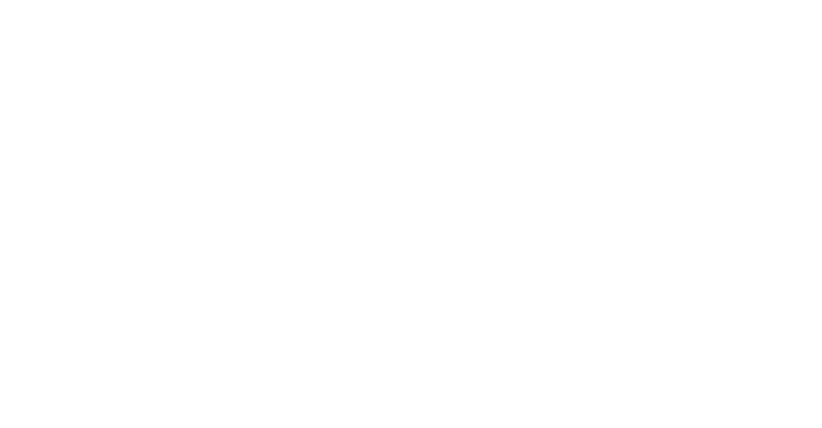

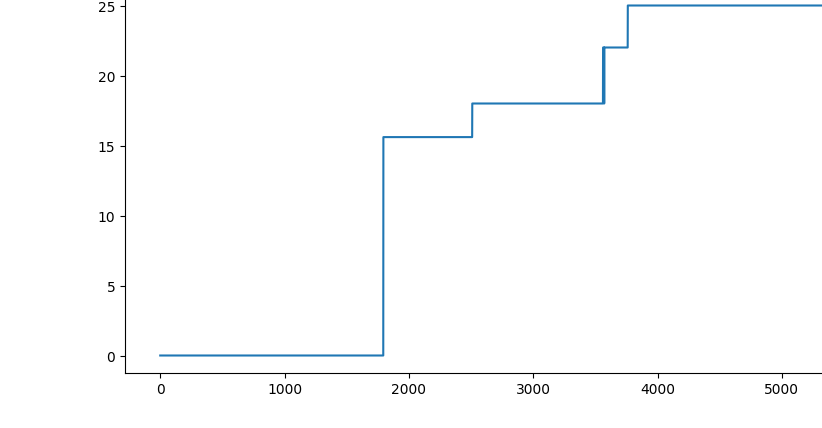

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x70628ffe4dd0>

<Figure size 1000x500 with 1 Axes>

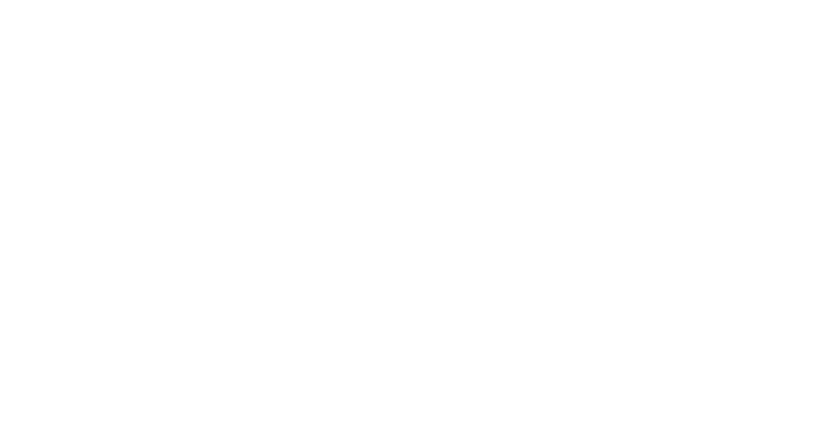

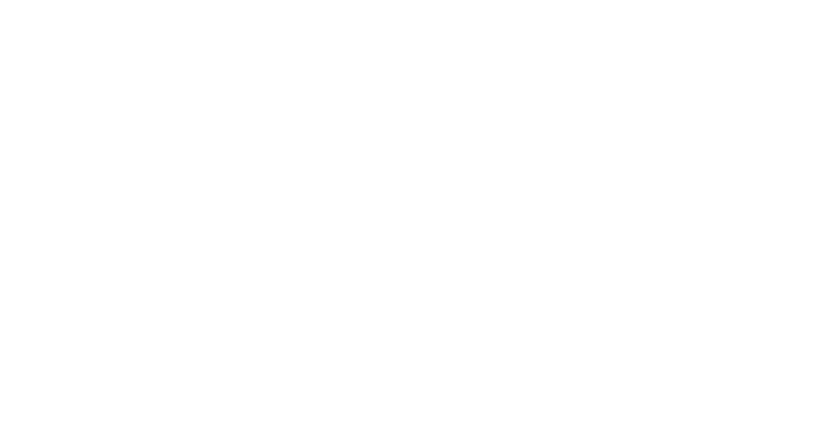

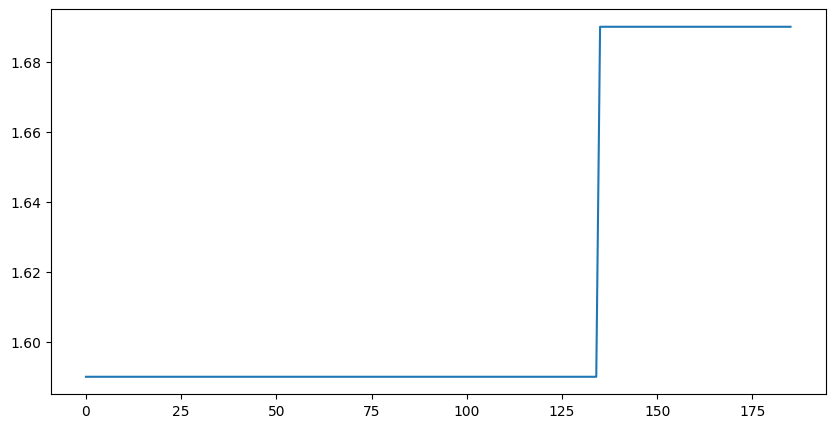

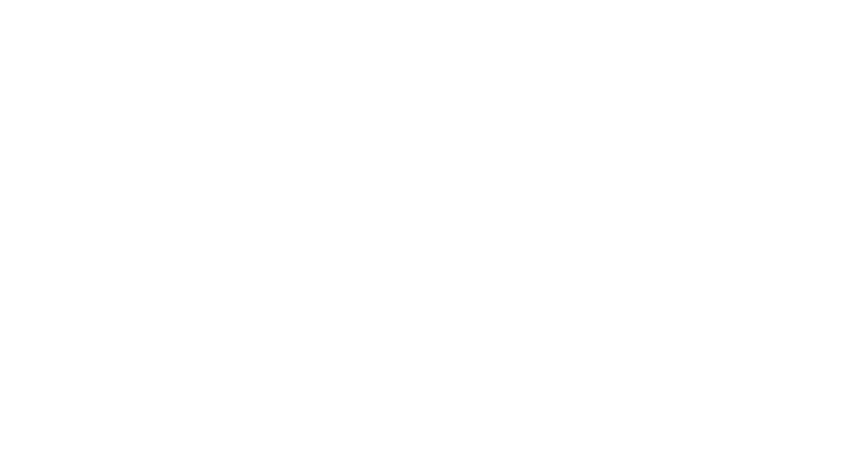

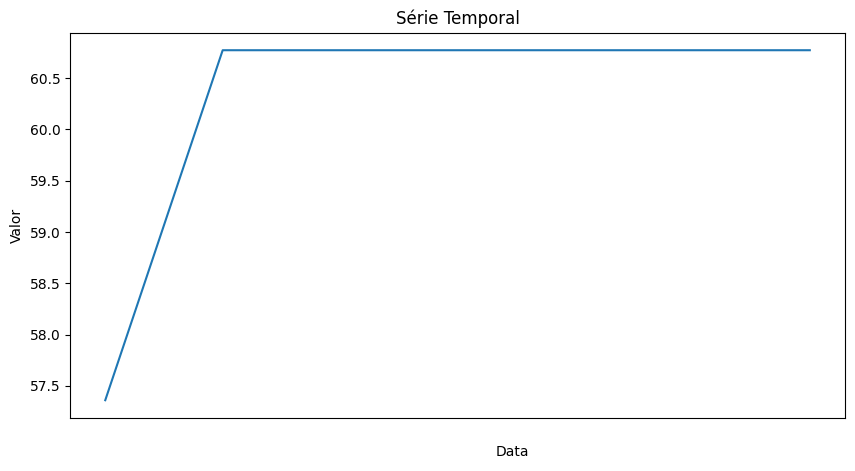

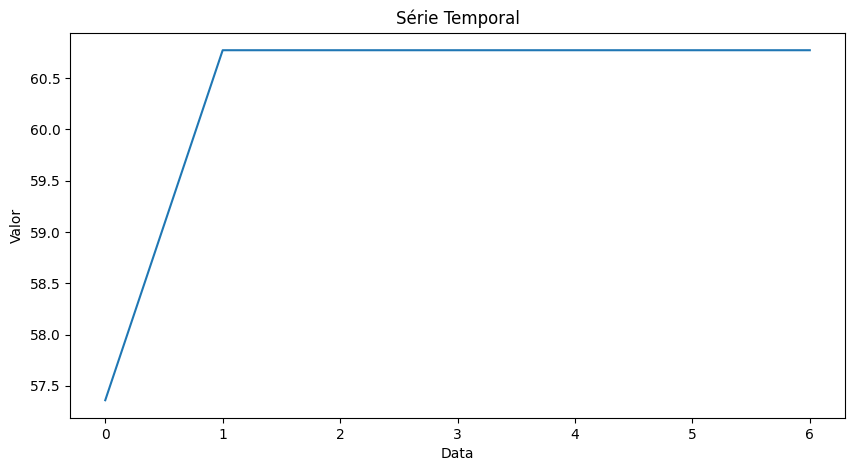

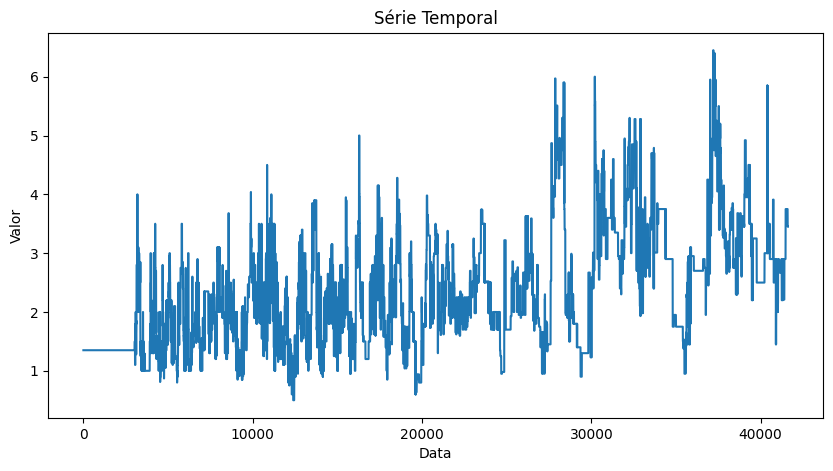

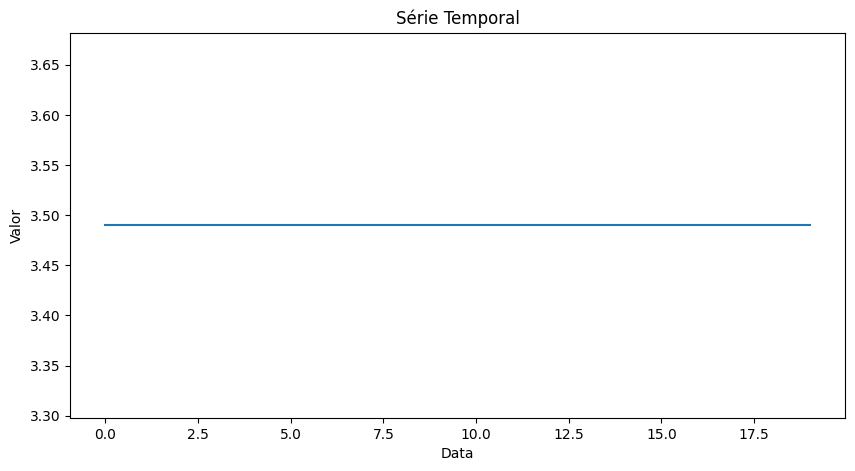

/home/jociano/Projects/promopredictor/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
imput_null_values('vendasprodutosexport', 'CodigoProduto', 'Data', ['ValorCusto', 'ValorUnitario'])

In [ ]:
# Simular dados para teste
data = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2020', periods=100, freq='M'),
    'Value1': range(100),
    'Value2': range(100, 200),
    'Value3': [x if x % 10 != 0 else None for x in range(200, 300)]  # Incluindo alguns valores nulos
})

# Exibir o DataFrame
print("Visualização do DataFrame:")
display(data.head())

# Testar a função com os dados simulados
arima_result = train_arima(data)
if arima_result:
    print(arima_result.summary())
else:
    print("Falha ao treinar o modelo.")

